Albocycline
===========

<!--<img title="https://pubchem.ncbi.nlm.nih.gov" src="https://pubchem.ncbi.nlm.nih.gov/image/imagefly.cgi?cid=6440973&width=500&height=500" align="center" height="400" width="400">-->


<hr style="height:2.5px">

<h2 style="align: center;font-size: 12pt;">Summary:</h2> Albocycline is a macrolactone isolated from Streptomyces maizeus.  This macrolactone has recently been identified as a promising lead antibiotic candidate for the treatment of both vancomycin-resistant S. aureus (VRSA) and MRSA.<br>
In our previous example we showed in detail how to calculate the consistency of theoretical modeling with experiment. The user gained insight on how to run `biceps` calculations in full. In this example, we will repeat the process parallelizing lambda values with `multiprocessing`.</h2>



**To convert this Jupyter Notebook into a script use the following command:**

```
$ jupyter nbconvert --to python albocycline.ipynb
```

<hr style="height:2.5px">

In [1]:
import numpy as np
import pandas as pd
import biceps

BICePs - Bayesian Inference of Conformational Populations, Version 2.0


In [7]:
####### Data and Output Directories #######
print(f"Possible input data extensions: {biceps.toolbox.list_possible_extensions()}")
energies = np.loadtxt('albocycline/albocycline_QMenergies.dat')*627.509  # convert from hartrees to kcal/mol
energies = energies/0.5959   # convert to reduced free energies F = f/kT
energies -= energies.min()  # set ground state to zero, just in case
dataFiles = 'albocycline/J_NOE'
input_data = biceps.toolbox.sort_data(dataFiles)
print(f"Input data: {biceps.toolbox.list_extensions(input_data)}")
outdir = 'results'
biceps.toolbox.mkdir(outdir)

Possible input data extensions: ['H', 'Ca', 'N', 'J', 'noe', 'pf']
Input data: ['J', 'noe']


In [8]:
####### Parameters #######

nsteps = 100000      # for testing
#nsteps=10000000     # for production

print(f"nSteps of sampling: {nsteps}")
n_lambdas = 3
lambda_values = np.linspace(0.0, 1.0, n_lambdas)
parameters = [
        {"ref": 'uniform', "sigma": (0.05, 20.0, 1.02)},
        {"ref": 'exp', "sigma": (0.05, 5.0, 1.02), "gamma": (0.2, 5.0, 1.01)}
        ]
pd.DataFrame(parameters)

nSteps of sampling: 100000


,ref,sigma,gamma
0,uniform,"(0.05, 20.0, 1.02)",NaN
1,exp,"(0.05, 5.0, 1.02)","(0.2, 5.0, 1.01)"


In [9]:
####### Multiprocessing Lambda values #######
@biceps.multiprocess(iterable=lambda_values)
def mp_lambdas(lam):
    ensemble = biceps.Ensemble(lam, energies)
    ensemble.initialize_restraints(input_data, parameters)
    sampler = biceps.PosteriorSampler(ensemble)
    sampler.sample(nsteps=nsteps, verbose=False)
    sampler.traj.process_results(f"{outdir}/traj_lambda{lam}.npz")

Number of CPUs: 6
Number of processes: 3

Accepted 71.197 % 


Accepted [ ...Nuisance paramters..., state] %
Accepted [32.584 31.728 31.728  6.885] % 


Accepted 67.116 % 


Accepted [ ...Nuisance paramters..., state] %
Accepted [32.699 31.904 31.904  2.513] % 


Accepted 71.872 % 


Accepted [ ...Nuisance paramters..., state] %
Accepted [32.641 32.005 32.005  7.226] % 



Loading results/traj_lambda0.0.npz ...
Loading results/traj_lambda0.5.npz ...
Loading results/traj_lambda1.0.npz ...
not all state sampled, these states [21 70] are not sampled
not all state sampled, these states [ 7  9 48] are not sampled
not all state sampled, these states [ 4  5  7  9 11 15 16 18 21 24 25 27 28 34 40 44 48 51 52 54 58 62 66 76
 77 81 82 86 87 94 95 98] are not sampled
Loading results/traj_lambda0.0.pkl ...
Loading results/traj_lambda0.5.pkl ...
Loading results/traj_lambda1.0.pkl ...
lam = [0.0, 0.5, 1.0]
nstates 100
Writing results/BS.dat...
Writing results/populations.dat...
Top 10 states: [45, 59, 91, 80, 37, 39, 38, 92, 46, 85]
Top 10 populations: [0.01937697 0.02055824 0.03569452 0.03953599 0.06008104 0.06297037
 0.09267405 0.12483458 0.20046525 0.24315789]


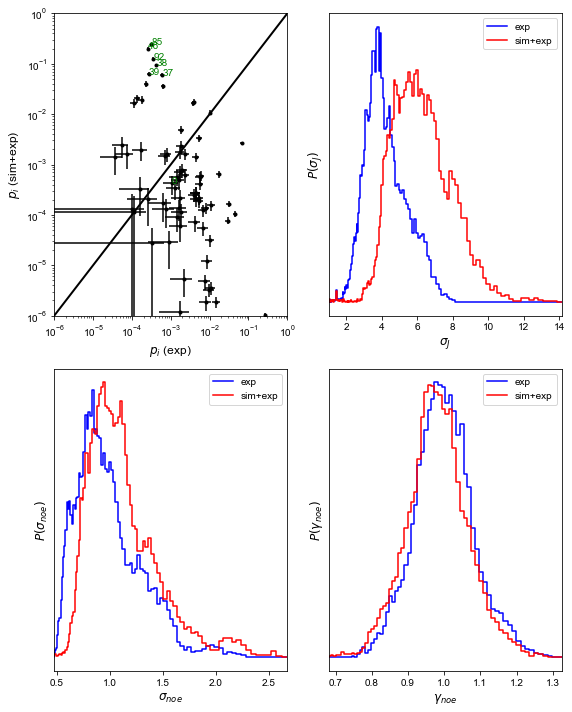

In [10]:
####### Posterior Analysis #######
A = biceps.Analysis(trajs=f"{outdir}/traj*.npz", nstates=len(energies))

ipython_warning = """# NOTE: This notebook was converted to a stand-alone python script albocycline.py using
#           $ jupyter nbconvert --to python albocycline.ipynb
#       but the only way "magic" inline functions work is through ipython:
#           $ ipython albocycline.py
#       For this reason, the following lines:
#           %matplotlib inline
#           A.plot()
#       are in a try/accept block"""
try:
    %matplotlib inline
    A.plot()
except:
    print(ipython_warning)

<h6 style="align: justify;font-size: 12pt"># <span style="color:red;">NOTE</span>: The following cell is for pretty notebook rendering</h6>

In [6]:
from IPython.core.display import HTML

def css_styling():
    styles = open("../../../theme.css", "r").read()
    return HTML(styles)

css_styling()